In [45]:
import json
from utils.all import *

# Allows interactive plotting
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import matplotlib.pyplot as plt, random

# data = load_data('../annotated', batch_num=[5, 6, 7, 8, 9, 10, 11], preprocess=True)
data = load_data('../data/inspection_rating_annotated', preprocess=True, adjudicated=True)

for sent in data:
    for annotation in sent['processed_annotations']:
        annotation['score'] = calculate_annotation_score(annotation, default_params)

INFO:Loading files: ['../data/inspection_rating_annotated/batch_1_ayush.json', '../data/inspection_rating_annotated/batch_1_rachel.json', '../data/inspection_rating_annotated/batch_1_vinayak.json', '../data/inspection_rating_annotated/batch_1_vishnesh.json', '../data/inspection_rating_annotated/batch_2_ayush.json', '../data/inspection_rating_annotated/batch_2_rachel.json', '../data/inspection_rating_annotated/batch_2_vinayak.json', '../data/inspection_rating_annotated/batch_2_vishnesh.json', '../data/inspection_rating_annotated/batch_3_ayush.json', '../data/inspection_rating_annotated/batch_3_rachel.json', '../data/inspection_rating_annotated/batch_3_vishnesh.json', '../data/inspection_rating_annotated/batch_4_ayush.json', '../data/inspection_rating_annotated/batch_4_rachel.json', '../data/inspection_rating_annotated/batch_4_vishnesh.json']

INFO:Found users: {'ayush', 'vinayak', 'vishnesh', 'rachel'}

DEBUG:Couldn't process grammar for deletion: ['bad', '', 'no', '']. Assuming 'no'...

In [46]:
all_components = []
gold_scores = []

for sent in data:
    content, syntax, lexical = 0, 0, 0
    content_error, syntax_error, lexical_error = 0, 0, 0

    for ann in sent['processed_annotations']:
        edit_score = None
        if ann['rating'] != None and ann['rating'] != '':
            edit_score = rating_mapping[annotation['rating']]
        rating = edit_score if edit_score is not None else 0

        # amt = rating
        amt = rating * (math.exp(ann['size']) - 1)
        # amt = rating * (1 + math.log10(ann['size'] + 0.1))

        # if sent['user'] != 'ayush':
        #     continue
        # if ann['family'] == Family.CONTENT:
        #     amt *= (1/50)
        # if ann['edit_type'] == 'insertion':
        #     continue

        # lexical, syntax, content error & quality
        if ann['type'] == Quality.QUALITY:
            if ann['family'] == Family.CONTENT:
                content += amt
            elif ann['family'] == Family.SYNTAX:
                syntax += amt
            elif ann['family'] == Family.LEXICAL:
                lexical += amt
        elif ann['type'] == Quality.ERROR:
            if ann['family'] == Family.CONTENT:
                content_error += amt
            elif ann['family'] == Family.SYNTAX:
                syntax_error += amt
            elif ann['family'] == Family.LEXICAL:
                lexical_error += amt

        # if ann['family'] == Family.CONTENT:
        #     content += amt
        # elif ann['family'] == Family.SYNTAX:
        #     syntax += amt
        # elif ann['family'] == Family.LEXICAL:
        #     lexical += amt

    if sent['simpeval_scores'] != None:
        all_components += [[content, syntax, lexical, content_error, syntax_error, lexical_error]]
        # all_components += [[content, syntax, lexical]]
        gold_scores += [2.5 * avg(sent['simpeval_scores'], prec=10)]

print(len(all_components))

import numpy as np
from sklearn.linear_model import LinearRegression
X = np.asarray(all_components)
y = np.asarray(gold_scores)
reg = LinearRegression().fit(X, y)
reg.score(X, y)
reg.coef_

print({
    'good_deletion': reg.coef_[0], 
    'good_insertion': reg.coef_[0],
    'good_syntax': reg.coef_[1],
    'good_paraphrase': reg.coef_[2],
    'good_trivial_insertion': 0,
    'content_error': reg.coef_[3],
    'syntax_error': reg.coef_[4],
    'lexical_error': reg.coef_[5],
    'grammar_error': reg.coef_[5],
    'size_calculation': 'exp'
})

688
{'good_deletion': 0.1955782614057374, 'good_insertion': 0.1955782614057374, 'good_syntax': 5.4916773148765285, 'good_paraphrase': 10.759154259512686, 'good_trivial_insertion': 0, 'content_error': -1.796703025226618, 'syntax_error': -5.051975242720761, 'lexical_error': 6.128637010080399, 'grammar_error': 6.128637010080399, 'size_calculation': 'exp'}


In [3]:
# Get the percentile of a score among some systems
get_percentile(data, 14.56)['all']

{'new-wiki-1/T5-3B': 100.0,
 'new-wiki-1/GPT-3-zero-shot': 100.0,
 'new-wiki-1/Human-2-written': 100.0,
 'new-wiki-1/Human-1-written': 100.0,
 'new-wiki-1/GPT-3-few-shot': 100.0,
 'new-wiki-1/T5-11B': 99.61832061068702,
 'new-wiki-1/Muss': 100.0}

DEBUG:Loaded backend module://ipykernel.pylab.backend_inline version unknown.
DEBUG:Loaded backend module://ipykernel.pylab.backend_inline version unknown.
DEBUG:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:findfont: score(FontEntry(fname='C:\\Users\\heine\\AppData\\Roaming\\Python\\Python39\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSansMono-BoldOblique.ttf', name='DejaVu Sans Mono', style='oblique', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:findfont: score(FontEntry(fname='C:\\Users\\heine\\AppData\\Roaming\\Python\\Python39\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXNonUniBolIta.ttf', name='STIXNonUnicode', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:findfont: score(FontEntry(fname='C:\\Users\\heine\\AppData\\Roaming\\Python\\Python39\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSansDisplay.ttf', na

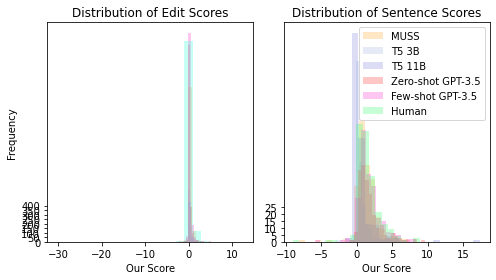

In [4]:
import random

systems = set([x['system'] for x in data])

n_bins = 20
fig, axs = plt.subplots(1, 2, tight_layout=True, figsize=(7, 4))

for system in [s for s in all_system_labels if s in systems and 'Human' not in s]:
    annotations = sorted([x for y in [sent['processed_annotations'] for sent in data if sent['system'] == system] for x in y], key=lambda x: x['score'])
    axs[0].hist([x['score'] for x in annotations], bins=n_bins, alpha=0.3, label=system_name_mapping[system], color=color_mapping[system])
    axs[1].hist([x['score'] for x in data if x['system'] == system], bins=n_bins, alpha=0.3, label=system_name_mapping[system], color=color_mapping[system])

# Only human annotations
annotations = sorted([x for y in [sent['processed_annotations'] for sent in data if 'Human' in sent['system']] for x in y], key=lambda x: x['score'])
edit_scores, sent_scores = [x['score'] for x in annotations], [x['score'] for x in data if 'Human' in x['system']]
axs[0].hist(random.sample(edit_scores, int(len(edit_scores)/2)), bins=n_bins, alpha=0.3, label='Human', color=color_mapping['new-wiki-1/Human 1 Writing'])
axs[1].hist(random.sample(sent_scores, int(len(sent_scores)/2)), bins=n_bins, alpha=0.3, label='Human', color=color_mapping['new-wiki-1/Human 2 Writing'])

axs[0].set_yticks(np.arange(0, 401, 50))
axs[1].set_yticks(np.arange(0, 26, 5))

axs[0].set_title("Distribution of Edit Scores")
axs[1].set_title("Distribution of Sentence Scores")

axs[0].set_ylabel("Frequency")
axs[0].set_xlabel("Our Score")
axs[1].set_xlabel("Our Score")

axs[1].legend()

out_filename = f'../paper/plot/score-distributions.pdf'
plt.savefig(out_filename, format="pdf", bbox_inches='tight', pad_inches=0.0)
plt.show()


AttributeError: 'AxesSubplot' object has no attribute 'is_first_col'

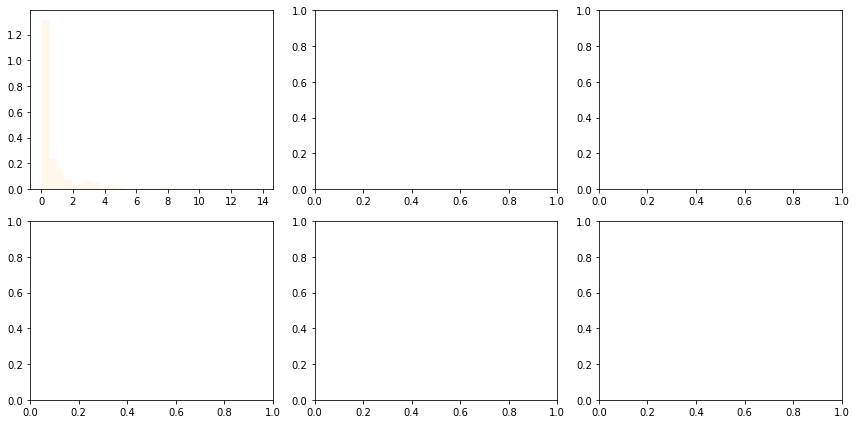

In [5]:
import pandas as pd

fig, axs = plt.subplots(2, 3, tight_layout=True, figsize=(12, 6))
n_bins = 30
bw_method = 0.2
comp_ratio = 3

chosen_systems = [
    'new-wiki-1/Muss',
    # 'new-wiki-1/T5-3B',
    # 'new-wiki-1/T5-11B',
    'new-wiki-1/GPT-3-zero-shot',
    'new-wiki-1/GPT-3-few-shot',
    'new-wiki-1/Human 1 Writing',
    'new-wiki-1/Human 2 Writing'
]
chosen_systems = [s for s in set([x['system'] for x in data]) if s in chosen_systems]

for j, segmentation in enumerate([['content', 'syntax', 'lexical'], ['quality', 'error', 'all']]):
    for i, dim in enumerate(segmentation):
        score_dim = f'{dim}'

        for system in [s for s in all_system_labels if s in chosen_systems and 'Human' not in s]:
            sent_scores = [x['subscores'][score_dim] for x in data if x['system'] == system]
            s = pd.Series(sent_scores)
            axs[j, i] = s.plot.hist(ax=axs[j, i], bins=n_bins, density=True, edgecolor='w', linewidth=0.5, alpha=0.1, label=system_name_mapping[system], color=color_mapping[system])
            axs[j, i] = s.plot.density(ax=axs[j, i], color=color_mapping[system], alpha=1, bw_method=bw_method)
            ax = plt.gca()

        sent_scores = [x['subscores'][score_dim] for x in data if 'Human' in x['system']]
        s = pd.Series(random.sample(sent_scores, int(len(sent_scores)/2)))
        axs[j, i] = s.plot.hist(ax=axs[j, i], bins=n_bins, density=True, linewidth=0.5, alpha=0.1, label='Human', color=color_mapping['new-wiki-1/Human 2 Writing'])
        axs[j, i] = s.plot.density(ax=axs[j, i], color=color_mapping['new-wiki-1/Human 2 Writing'], alpha=1, bw_method=bw_method)

        xlim, ylim = axs[j, i].get_xlim(), axs[j, i].get_ylim()
        axs[j, i].set_xlim((-max(xlim)/comp_ratio, max(xlim)/comp_ratio))
        axs[j, i].set_ylim(ylim)

        axs[j, i].set_xlabel(f'{dim.capitalize()} Score')
        axs[j, i].set_ylabel("")

    axs[j, 0].set_ylabel("Density")
axs[1, 2].legend(frameon=False)
out_filename = f'../paper/plot/performance-distribution.pdf'
plt.savefig(out_filename, format="pdf", bbox_inches='tight', pad_inches=0.0)
plt.show()

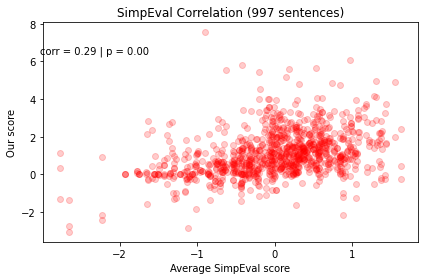

In [ ]:
# Graph agreement with SimpEval
data = calculate_sentence_scores(data)
simpeval_agreement(data)

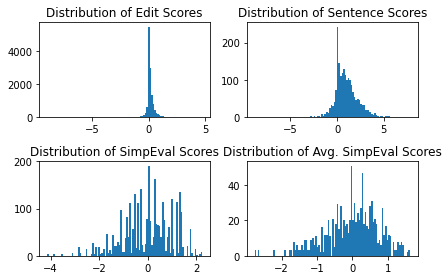

In [ ]:
# Show the distribution of edit and sentence scores
score_distribution(data, include_simpeval=True)

In [ ]:
# & -- & -- & -- & -- & -- & -- & -- & -- \tabularnewline

# Print the avg. sentence scores for each system
table = ''

subscores = ['lexical', 'syntax', 'content', 'error', 'quality']

std = lambda x: round(np.std(x, ddof=1), 2)

for system in [s for s in all_system_labels if s in systems and 'Human' not in s] + ['aggregated/human']:
    selected = [sent for sent in data if sent["system"] == system]
    if system == 'aggregated/human':
        selected = [sent for sent in data if 'Human' in sent['system']]

    line = f'{system_name_mapping[system]} & '

    for score in subscores:
        selected_scores = [s["subscores"][score] for s in selected]
        line += f'{avg(selected_scores, 2):.2f} & {std(selected_scores):.2f} & '

    selected_scores = [s["score"] for s in selected]
    line += f'{avg(selected_scores, 2):.2f} & {std(selected_scores):.2f}'

    table += f'{line} \\tabularnewline\n'
print(table)

MUSS & 0.43 & 0.64 & 0.24 & 0.50 & -0.00 & 1.21 & -0.32 & 0.50 & 1.17 & 0.99 & 0.78 & 1.22 \tabularnewline
T5 3B & 0.09 & 0.21 & 0.05 & 0.58 & -0.05 & 0.76 & -0.19 & 0.62 & 0.43 & 0.50 & 0.23 & 0.83 \tabularnewline
T5 11B & 0.06 & 0.16 & 0.03 & 0.13 & -0.13 & 0.82 & -0.17 & 0.36 & 0.28 & 0.43 & 0.11 & 0.58 \tabularnewline
Zero-shot GPT-3.5 & 0.52 & 0.70 & 0.16 & 0.56 & 0.58 & 0.74 & -0.23 & 0.45 & 1.55 & 1.00 & 1.32 & 1.12 \tabularnewline
Few-shot GPT-3.5 & 0.61 & 0.71 & 0.22 & 0.49 & 0.51 & 0.76 & -0.16 & 0.36 & 1.57 & 1.04 & 1.41 & 1.13 \tabularnewline
Human & 0.54 & 0.65 & 0.26 & 0.57 & 0.64 & 0.97 & -0.18 & 0.42 & 1.74 & 1.15 & 1.55 & 1.25 \tabularnewline



In [ ]:
from scipy.stats import kendalltau
from scipy.stats import pearsonr
import krippendorff

# Calculates sentence-score agreement
def calculate_agreement(data):
    total_agreement = None
    MAX_HIT = max([x['id'] for x in data])+1
    for sent_id in range(0, MAX_HIT):
        sents = [x for x in data if x['id'] == sent_id]
        scores = [sent['score'] for sent in sents]
        if len(scores) == 3:
            if total_agreement is None:
                total_agreement = np.asarray([scores])
            else:
                total_agreement = np.append(total_agreement, np.asarray([scores]), axis=0)
    print(total_agreement.T.shape)
    return krippendorff.alpha(reliability_data=total_agreement[:300, :].T, level_of_measurement='interval')
    # return krippendorff.alpha(value_counts=total_agreement, level_of_measurement='nominal')

In [ ]:
param_sets = {
    'current': {
        'good_deletion': 0.92318339, 
        'good_insertion': 0.92318339,
        'good_syntax': 0.73494346, 
        'good_paraphrase': 1.20408166, 
        'good_trivial_insertion': 0,
        'content_error': -0.2461172, 
        'syntax_error': -1.32678149, 
        'lexical_error': -0.25790779,
        'grammar_error': -0.25790779,
        'size_calculation': 'exp'
    },
    'agreement_2': {
        'good_deletion': 0.41426288, 
        'good_insertion': 0.41426288,
        'good_syntax': 0.78057733, 
        'good_paraphrase': 1.1368266, 
        'good_trivial_insertion': 0,
        'content_error': -0.41426288, 
        'syntax_error': -0.78057733, 
        'lexical_error': -1.1368266,
        'grammar_error': -1.1368266,
        'size_calculation': 'exp'
    },
    'agreement_2': {
        'good_deletion': 1.0356572, 
        'good_insertion': 1.0356572,
        'good_syntax': 1.95144333, 
        'good_paraphrase': 2.84206649, 
        'good_trivial_insertion': 0,
        'content_error': -1.0356572, 
        'syntax_error': -1.95144333, 
        'lexical_error': -2.84206649,
        'grammar_error': -2.84206649,
        'size_calculation': 'exp'
    }
    # 1.0356572 , 1.95144333, 2.84206649
}
for param in reversed(list(param_sets.keys())):
    print(param)
    out = copy.deepcopy(data)
    for sent in out:
        try:
            sent['score'] = calculate_sentence_score(sent, param_sets[param])
        except Exception as e:
            continue
    print(calculate_agreement(out))

agreement_2
(3, 591)
0.4884366814573342
current
(3, 591)
0.4608065548030096


In [ ]:
# Attempt to replicate simpeval agreement calculation
total_agreement = None
MAX_HIT = max([x['id'] for x in data])+1
for sent_id in range(0, MAX_HIT):
    sents = [x for x in data if x['id'] == sent_id]
    scores = [sent['simpeval_scores'] for sent in sents][0]
    if scores is not None and len(scores) == 3:
        if total_agreement is None:
            total_agreement = np.asarray([scores])
        else:
            total_agreement = np.append(total_agreement, np.asarray([scores]), axis=0)

# total_agreement is correct, this should be 0.32
print(total_agreement.T.shape)
krippendorff.alpha(reliability_data=total_agreement.T, level_of_measurement='interval')

(3, 357)


0.3270384070659148

In [ ]:
# This is my first time using iPy, so this is a bit clunky...
def series(
    data, 
    average, 
    user,
    good_deletion=default_params['good_deletion'], 
    good_trivial_insertion=default_params['good_trivial_insertion'], 
    good_insertion=default_params['good_insertion'], 
    good_paraphrase=default_params['good_paraphrase'], 
    good_syntax=default_params['good_syntax'], 
    grammar_error=default_params['grammar_error'], 
    content_error=default_params['content_error'], 
    size_calculation=default_params['size_calculation'],
    display_distribution=False
    ):
    params = {
        'good_deletion': good_deletion,
        'good_trivial_insertion': good_trivial_insertion,
        'good_insertion': good_insertion,
        'good_paraphrase': good_paraphrase,
        'good_syntax': good_syntax,
        'grammar_error': grammar_error,
        'content_error': content_error,
        'size_calculation': size_calculation
    }

    selected_data = data
    if user != 'all':
        selected_data = [sent for sent in selected_data if sent['user'] == user]

    selected_data = calculate_sentence_scores(selected_data, params)
    simpeval_agreement(selected_data, average)
    if (display_distribution):
        score_distribution(selected_data)
    return()

interact(
    series, 
    data=[data], 
    good_deletion=(-20,20,0.5), 
    good_trivial_insertion=(-20,20,0.5), 
    good_insertion=(-20,20,0.5), 
    good_paraphrase=(-20,20,0.5), 
    good_syntax=(-20,20,0.5), 
    grammar_error=(-20,20,0.5), 
    content_error=(-20,20,0.5),
    size_calculation=['linear', 'log', 'exp', 'square', 'none'],
    average=[True, False],
    user=['all'] + sorted(list(set([sent['user'] for sent in data]))),
    display_distribution=[True, False]
)

interactive(children=(Dropdown(description='data', options=([{'id': 0, 'original': "The architecture of Winche…

<function __main__.series(data, average, user, good_deletion=3.69273355, good_trivial_insertion=0, good_insertion=3.69273355, good_paraphrase=4.81632663, good_syntax=2.93977382, grammar_error=-1.03163116, content_error=-0.98446881, size_calculation='exp', display_distribution=False)>